### <b> Calculating the luminosity of a polytrope of index n </b>

In [11]:
from polytrope_model import lane_emden_sys, lane_emden_solver
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Chemical compostion (H and He)
def chemical_composition(xi, X_s, r_c, d_c, R, time, total_time, Z_s):

    # Hidrogen
    X_c = X_s - X_s * (time/total_time)
    X = X_c + (X_s - X_c)/(1+np.exp((r_c-xi)/(R*d_c)))
    
    # Helium
    Y = 1 - Z_s - X

    return X, Y

In [ ]:
# Thermodynamic functions (general and center)

def density(M, R, n):
    xi, y1, y2 = lane_emden_solver(n)
    a_n = -xi[-1]/(3*y2[-1])
    central_density = M/(4/3*np.pi*R**3) * a_n
    density = central_density * y1**n

    return density, central_density

def pressure(G, M, R, n):
    xi, y1, y2 = lane_emden_solver(n)
    c_n = 1 / (4 * np.pi * (n+1) * y2[-1]**2)
    central_pressure = (G*M**2)/R**4 * c_n
    pressure = central_pressure * y1**(n+1)

    return pressure, central_pressure

def temperature(G, M, R, X, Z, R_g, n): # R_g = gas constant, G  (define both as global variables?)
    xi, y1, y2 = lane_emden_solver(n)
    mu = 4/(5*X-Z+3)
    b_n = 1 / (n+1) * xi[-1] * (-y2[-1])
    central_temperature = mu*G*M/(R_g*R) * b_n
    temperature = central_temperature *  y1

    return temperature, central_temperature

In [ ]:
def emissivity(rho, T, X, Z):
    T6 = T/1e6

    T_og_length = len(T6) # original length of T6 array
    T_new_length = 1 + int(np.argwhere(T6<1e-3)[0]) # the remaining values of T6 might cause numerically unstable values of emissivity 
    size_dif = T_og_length - T_new_length

    # Update array sizes for emissivity calculations
    T6 = T6[:T_new_length]
    X = X[:T_new_length]
    rho = rho[:T_new_length]
    e_0 = 2.38e106*X**2*rho

    # Formula variables
    alpha = 1.2e17*((1-X-Z)/(4*X))**2 * np.exp(-100*T6**(-1/3))
    eps_0 = 2.38e6* X** 2 * rho* T6** (-2/3) * (1 + 0.0123*T6** (1/3) + 0.0109*T6** (2/3) + 0.00095*T6) * np.exp(-33.80*T6** (-1/3) + 0.27*rho** (1/2)* T6**(-3/2))
    phi_alpha = 1-alpha + np.sqrt(alpha*(alpha+2))
    F1 = (np.sqrt(alpha+2) - np.sqrt(alpha))/(np.sqrt(alpha+2) + 3*np.sqrt(alpha))
    F2 = (1-F1)/(1+8.94e15 * (X/(4-3*X))* T6**(-1/6) * np.exp(-102.65*T6**(-1/3)))
    F3 = 1-F1-F2

    # Emissivity: proton-proton (e_pp), carbon-nitrogen-oxigen (e_cno)
    e_pp = (eps_0/0.980) * phi_alpha * (0.980*F1 + 0.960*F2 + 0.721*F3)
    e_cno = 8.67e27*Z*X*rho*T6** (-2/3) * (1 + 0.0027*T6** (1/3) - 0.00778*T6** (2/3) - 0.000149*T6) * np.exp(-152.28*T6**(-1/3))

    # Fill the arrays back to their original sizes with zeros (further calculations using emissivity won't be affected)
    zeros = np.zeros(size_dif)
    e_pp = np.concatenate((e_pp, zeros))
    e_cno = np.concatenate((e_cno, zeros))

    # Total emissivity
    e_total = e_pp + e_cno

    return e_total, e_pp, e_cno

In [ ]:
def luminosity(n, X_s, r_c, d_c, R, time, total_time, Z_s, M, G, Z, R_g, L_sol ):

    # xi, theta(xi), theta'(xi)
    xi, y1, y2 = lane_emden_solver(n)

    # chemical composition X, Y
    X, Y = chemical_composition(xi, X_s, r_c, d_c, R, time, total_time, Z_s)

    # Thermodynamic functions (general and center)
    rho, rho_c = density(M, R, n)
    P, P_c = pressure(G, M, R, n)
    T, T_c = temperature(G, M, R, X, Z, R_g, n)

    # Emissivity
    ems_tot, e_pp, e_cno = emissivity(rho, T, X, Z)

    # Constant of the luminosity formula
    const = -1/(xi[-1]**2 * y2[-1])

    # Integrand of the formula
    integrand = xi**2 * y1**n *M*ems_tot/L_sol

    # Cumulative integral
    integral = cumulative_trapezoid(integrand, xi, initial = 0)
    return integral


/Users/rodrigocastro/Desktop/Computational_Astronomy/polytrope_model.py:29: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(lane_emden_sys, lane_em_0, xi_range, args=(n,), tfirst=True)
/var/folders/vw/fb5g0yw578jfpvmgdl2bgkr80000gn/T/ipykernel_13363/1057902607.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_new_length = 1 + int(np.argwhere(T6<1e-3)[0]) # the remaining values of T6 might cause numerically unstable values of emissivity


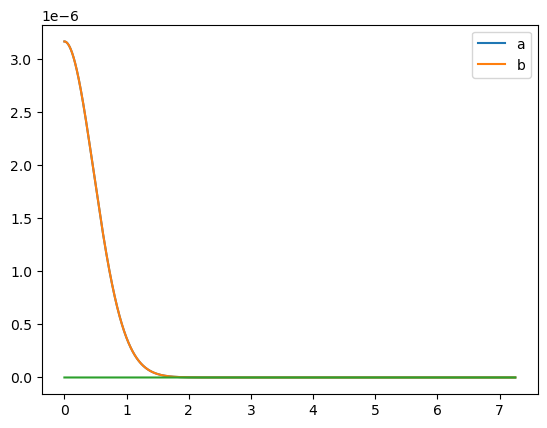

In [ ]:
# Global
G = 6.67408e-8 # gravitational constant
R_g = 8.314511e7 # gas constant

#Sun
M_sol = 1.988475e33
L_sol = 3.828e33
R_sol = 6.957e10
Z_sol = 0.02857
Y_sol = 0.28

n_sol = 3.08692
X_s_sol = (1-Y_sol)/(1+Z_sol)
Z_sol = 1-Y_sol-X_s_sol
xi, y, z = lane_emden_solver(n_sol)
X_sol, Y_sol= chemical_composition(xi, X_s_sol, 0.2, 0.03, R_sol, 1, 2, Z_sol)
rho, rho_c = density(M_sol, R_sol, n_sol)
P, P_c = pressure(G, M_sol, R_sol, n_sol)
T, T_c = temperature(G, M_sol, R_sol, X_sol, Z_sol, R_g, n_sol)
e, epp, ecno = emissivity(rho, T, X_sol, Z_sol)

plt.plot(xi, e, label='a')
plt.plot(xi, epp, label='b')
plt.plot(xi, ecno)
plt.legend()


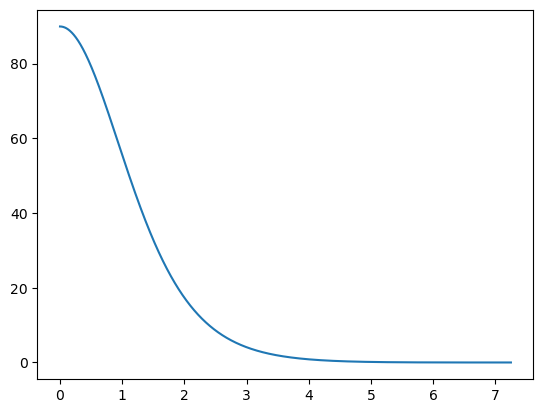

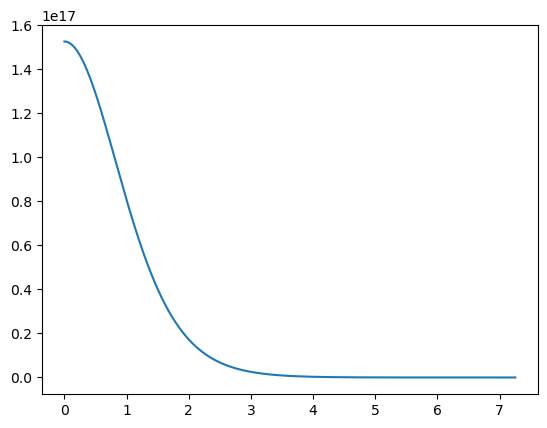

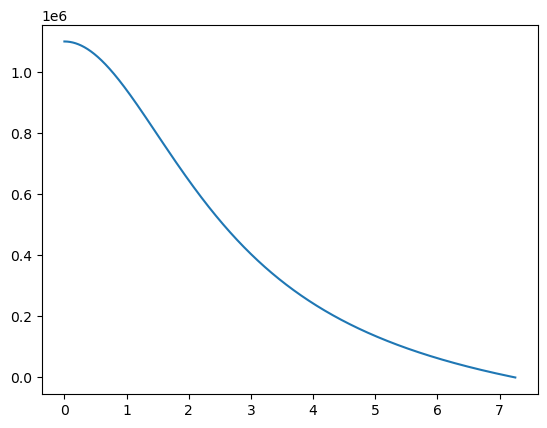

In [13]:
plt.plot(xi, rho)
plt.show()
plt.plot(xi, P)
plt.show()
plt.plot(xi, T)
plt.show()